In [ ]:
# https://github.com/brainhack-school2020/stong3_fMRI_processing/blob/master/fMRIPrep_tutorial/post-processing-nilearn.py
"""
Script - Post-processing fMRI images with Nilearn to obtain connectivity matrices
Author: Frédéric St-Onge
Date created: June 3rd 2020
Date modified: June 3rd 2020
Purpose:
    This script aims to import pre-processed images and confounds list from fMRIPrep and generate connectivity
    matrices based on the Schaefer Atlas parcellation. The script uses lists to iterate over nested loops to
    generate outputs for different subjects/sessions/confounds/kind of connectivity matrices.
Version: 0.1
Future updates:
- Integrate argument parsers for the subjects/sessions/confounds/kind of connectivity matrices
- Modify the pipeline to further scrub the frame-wise displacement? (look at fmripop: https://github.com/brain-modelling-group/fmripop)
- Integrate with pybids in the sourcefolder to obtain a list of all subjects to process. This would allow less trouble with
creating lists manually.3
"""




In [16]:
#First step: Import necessary packages for the full script
import datetime
import nilearn
from nilearn import datasets #For atlases
from nilearn import plotting #To plot brain images
from nilearn.input_data import NiftiLabelsMasker #To mask the data
from nilearn.connectome import ConnectivityMeasure #To compute the connectivity matrices
from pathlib import Path
import pandas as pd #For dataframe manipulation (e.g. confound file)
# importing pyplot and image from matplotlib
from matplotlib import image as img
from matplotlib import pyplot as plt #Used to bypass a bug where the figures wouldn't close in Nilearn
import numpy as np #To convert our confounds to numpy array
import os #To create directories in the loop
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
print(nilearn.__version__)

0.8.0


In [ ]:
subject_list = ['sub-003', 'sub-004', 'sub-006', 'sub-009', 'sub-011', 'sub-012', 'sub-014', 'sub-019', 'sub-021',
                'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-028', 'sub-031', 'sub-035', 'sub-036', 'sub-041',
                'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-050', 'sub-056', 'sub-057', 'sub-058', 'sub-059',
                'sub-060', 'sub-061', 'sub-062', 'sub-064', 'sub-065', 'sub-068', 'sub-070', 'sub-071', 'sub-073',
                'sub-075', 'sub-076', 'sub-078', 'sub-079', 'sub-081', 'sub-082', 'sub-084', 'sub-085', 'sub-086', 
                'sub-087', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-097', 'sub-099', 
                'sub-100', 'sub-101', 'sub-104', 'sub-106', 'sub-107', 'sub-108', 'sub-111', 'sub-112', 'sub-114', 
                'sub-117', 'sub-118', 'sub-122', 'sub-124', 'sub-125', 'sub-127', 'sub-128', 'sub-129', 'sub-131', 
                'sub-132', 'sub-133', 'sub-134', 'sub-135', 'sub-138', 'sub-139', 'sub-141', 'sub-142', 'sub-145', 
                'sub-146', 'sub-147', 'sub-148', 'sub-151', 'sub-153', 'sub-154', 'sub-155', 'sub-156', 'sub-157']

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Description of fmriprep post-processing: 
    Subjects to be processed: ['sub-009']
    Session to be processed: ['ses-01', 'ses-02']
    Confounds to be regressed out: ['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'cosine00', 'cosine01', 'cosine02']
    Correlation matrices to be generated: ['correlation', 'partial correlation']
    All procedures will be done with the Schaefer200 atlas.
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 
Starting postprocessing for subject sub-009 for session ses-01
---------------------------------------------------------------------
Fetching the paths for the fMRI files and the confound files...
The path for the fmri file is: /fast_scratch/jdr/resting/BIDS_fmriprep/fmriprep//sub-009/ses-01/func/sub-009_ses-01_task-EPIresting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
The path for the full confoun

,subject,session,numOriginalTRs,numScrubbedTRs,numRemainingTRs,percentScrubbed,originalLengthMin,remainingLengthMin
0,sub-009,ses-01,147,34,113,23.13,05:14,04:01


Extracting connectivity matrices...
The shape of the correlation matrix is:  (200, 200)
Testing if the shape of the matrix matches the length of the list of atlas labels...
All good...
Creating a Pandas dataframe with the atlas labels as the index...
Creating a directory to save the computed correlation matrices...
Directory /fast_scratch/jdr/resting/connMatrices//sub-009/ses-01/correlation/ already exists.
Saving dataframe to a .csv file in: /fast_scratch/jdr/resting/connMatrices//sub-009/ses-01/correlation/
The shape of the correlation matrix is:  (200, 200)
Testing if the shape of the matrix matches the length of the list of atlas labels...
All good...
Creating a Pandas dataframe with the atlas labels as the index...
Creating a directory to save the computed correlation matrices...
Directory /fast_scratch/jdr/resting/connMatrices//sub-009/ses-01/partial correlation/ already exists.
Saving dataframe to a .csv file in: /fast_scratch/jdr/resting/connMatrices//sub-009/ses-01/partial cor

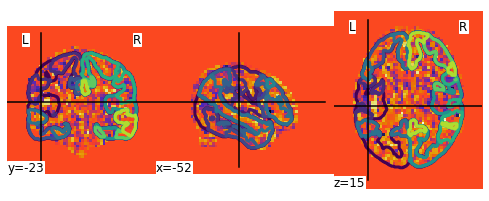

In [33]:
subjects_location = '/fast_scratch/jdr/resting/BIDS_fmriprep/fmriprep/'
connectivity_matrices_dir = '/fast_scratch/jdr/resting/connMatrices/'

#This part creates the root directory inside of the derivatives folder, specified by the BIDS convention. The path above should reflect where you want the directory to go.
#Even if the intermediate path (derivatives) is not created yet, the function 'makedirs' creates it for you.
if not os.path.exists(connectivity_matrices_dir):
    os.makedirs(connectivity_matrices_dir)
    
subject_list = ['sub-009']
session_list = ['ses-01', 'ses-02']
confound_list = ['csf', 'white_matter', 'global_signal', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'cosine00', 'cosine01', 'cosine02']
kind_connectivity = ['correlation', 'partial correlation']
atlas = 'Schaefer200'
atlas_schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200)
atlas_filename_schaefer = atlas_schaefer.maps 
labels_schaefer = atlas_schaefer.labels 

# Create data frame to hold postprocessing statistics
col_names =  ['subject', 'session', 'numOriginalTRs', 'numScrubbedTRs', 'numRemainingTRs', 'percentScrubbed', 'originalLengthMin', 'remainingLengthMin']
postproc_stats  = pd.DataFrame(columns = col_names)

print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print('Description of fmriprep post-processing: ')
print(f'    Subjects to be processed: {subject_list}')
print(f'    Session to be processed: {session_list}')
print(f'    Confounds to be regressed out: {confound_list}')
print(f'    Correlation matrices to be generated: {kind_connectivity}')
print(f'    All procedures will be done with the {atlas} atlas.')
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
print(' ')

for subject in subject_list:
    for session in session_list:
        subject_session_location = f'{subjects_location}/{subject}/{session}'
        if Path(subject_session_location).exists():
            scrubbed_percentage, deConf_scrubbed_fmri_img = postproc(subject, session)
            if scrubbed_percentage < 25:
                createConns(subject, session, deConf_scrubbed_fmri_img)
            else:
                print('___________________________________________________________')
                print('WARNING: Skipping scan for {}, {} - {} of TRs were scrubbed'.format(subject, session, scrubbed_percentage))
                print('-----------------------------------------------------------')

In [32]:
def remove_confounds(fmriFile, maskFile, confoundsFile):
    this_dtype = np.float32
    confounds = pd.read_csv(confoundsFile, sep='\t')
    confounds_ra = confounds.to_records(index=False)
    nTRs, _ = confounds.shape
    confounds_signals = np.zeros((nTRs, len(confound_list)))
    for idx, aConfound in enumerate(confound_list):
        confounds_signals[:,idx] = confounds_ra[aConfound]
    #Clean image
    temp_img = nilearn.image.clean_img(fmriFile, standardize=True, confounds=confounds_signals, 
                                       t_r=2.14, high_pass=0.01, low_pass=0.1, mask_img=maskFile)
    *xyz, time_frames = temp_img.shape
    data = np.zeros(temp_img.shape)
    for this_frame in range(time_frames):
        # Cache image data into memory and cast them into float32 
        data[..., this_frame] = temp_img.get_fdata(dtype=this_dtype)[..., this_frame]
    out_img = nilearn.image.new_img_like(temp_img,data)
    return out_img
    
def scrubbing(deConfounded_fmri_img, maskFile, confoundsFile, fd_threshold, tr):
    # Name of FD column in confounds file
    fd_label = "framewise_displacement"
    # Confounds to df
    confounds = pd.read_csv(confoundsFile, sep='\t')
    # Remove row indices
    ra = confounds.to_records(index=False)
    # Get original nummber of TRs
    nTRs, _ = confounds.shape
    # Get vector of FD values
    fd_vec = ra['framewise_displacement']
    # fmriprep *prepends* nan in the FD vector, other approaches *append* a 0 at the end of the vector
    # Here we shift the FD vector to match 'typical' approaches in the literature
    ## Slide (roll) all values back one (puts the 'nan' at the end)
    fd_vec = np.roll(fd_vec, -1)
    ## Change the last value (now 'nan') to zero
    fd_vec[nTRs - 1] = 0
    # Binarize FD vector using specified FD threshold value
    above_threshold = 1
    below_threshold = 0
    fd_bin = np.where(fd_vec > fd_threshold, above_threshold, below_threshold)
    # Create FD vector that counts number of 'bad' TRs in a row
    frame_idx_before_a = -1
    frame_idx_contaminated_a = 0
    frame_idx_contaminated_b = 1
    frame_idx_after_b = 2
    # Create a dummy fd_bin vector padded with zeros so we can create the scrub mask with circular shifts
    fd_bin_pad = np.pad(fd_bin, (-frame_idx_before_a, frame_idx_after_b), 'constant', constant_values=(0, 0))
    # Create the scrubbing mask. This mask can be used for other stats, such as longest sequence of contaminated volumes.
    scrub_mask = (np.roll(fd_bin_pad, frame_idx_before_a) + fd_bin_pad + np.roll(fd_bin_pad, frame_idx_contaminated_b) + np.roll(fd_bin_pad, frame_idx_after_b))[-frame_idx_before_a:-frame_idx_after_b]
    # Create a boolean mask. A value of False indicates that the element/subarray should be deleted 
    scrub_mask_bool = np.where(scrub_mask >= above_threshold, False, True)
    # Calculate scrubbing statistics
    nTRs, *_ = scrub_mask_bool.shape
    badTRs = (~scrub_mask_bool).sum()
    scrubbed_percentage = round(((badTRs / nTRs)*100), 2)
    # Get length in minutes
    original_length_raw = (nTRs * tr)/60.0
    original_length_time = (datetime.time(minute = int(original_length_raw), 
                                         second = int((original_length_raw - 
                                                       int(original_length_raw))*60.0))).strftime('%M:%S')
    remaining_length_raw = ((nTRs - badTRs)*tr)/60.0    
    remaining_length_time = (datetime.time(minute = int(remaining_length_raw), 
                                           second = int((remaining_length_raw - 
                                                int(remaining_length_raw))*60.0))).strftime('%M:%S')
    # Remove bad TRs
    ## Returns a 2D array of shape timepoints x (voxels_x * voxels_y * voxels_z)
    masked_data = nilearn.masking.apply_mask(deConfounded_fmri_img, maskFile)
    ## In the boolean scub_mask_bool, False indicates that the element/subarray should be deleted 
    masked_data = masked_data[scrub_mask_bool, :]
    out_img = nilearn.masking.unmask(masked_data.astype(np.float32), maskFile)

    return nTRs, scrubbed_percentage, badTRs, original_length_time, remaining_length_time, out_img
    
def postproc(subject, session):
    #First, we need to import the paths where the fMRI pre-processed and confounds files are stored. They follow BIDS convention and depend on the path provided
    #for the subject location. After fetching the paths, we print them.

    print(f'Starting postprocessing for subject {subject} for session {session}')
    print('---------------------------------------------------------------------')
    print('Fetching the paths for the fMRI files and the confound files...')
    pre_processed_fmri_file = f'{subject_session_location}/func/{subject}_{session}_task-EPIresting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    pre_processed_mask_file = f'{subject_session_location}/func/{subject}_{session}_task-EPIresting_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
    full_confound_file_fmriprep = f'{subject_session_location}/func/{subject}_{session}_task-EPIresting_desc-confounds_timeseries.tsv'
    print(f'The path for the fmri file is: {pre_processed_fmri_file}')
    print(f'The path for the full confound file is: {full_confound_file_fmriprep}')
    print('----------------------------------------------------------------------')
    deConfounded_fmri_img = remove_confounds(pre_processed_fmri_file, pre_processed_mask_file, full_confound_file_fmriprep)
    nTRs, scrubbed_percentage, badTRs, original_length_time, remaining_length_time, deConf_scrubbed_fmri_img = scrubbing(deConfounded_fmri_img, 
                                                                                             pre_processed_mask_file, full_confound_file_fmriprep,  0.4, 2.14)
    remainingTRs = nTRs - badTRs
    postproc_stats.loc[len(postproc_stats)] = [subject, session, nTRs, badTRs, remainingTRs, 
                                               scrubbed_percentage, original_length_time, remaining_length_time]
    display(postproc_stats)
    return scrubbed_percentage, deConf_scrubbed_fmri_img


def createConns(subject, session, deConf_scrubbed_fmri_img):
    
    # We are now ready to extract the time series using our atlas mask
    # from nilearn.input_data import NiftiLabelsMasker #Already imported in the top of the script
    masker = NiftiLabelsMasker(labels_img=atlas_filename_schaefer, standardize=True, verbose=0)
    masker.fit(deConf_scrubbed_fmri_img)
    time_series = masker.transform(deConf_scrubbed_fmri_img)
    report = masker.generate_report()
    #We are now ready to extract the connectivity matrix using Nilearn functions.
    #This part of the script will:
    ## 1) Create a loop to extract matrices according to the kind of matrix wanted (e.g. correlation, partial correlation, etc.)
    ## 2) Check that the matrix shape matches the length of the atlas labels
    ## 3) Create a Pandas dataframe with the labels as columns and indices
    ## 4) Create a directory where we can save the matrix ('bids-like')
    ## 5) Export the dataframe to a .csv file 
    ## 6) Use Nilearn functions to plot the matrix with labels
    ## 7) Save the image in the same directory as the .csv file.

    ### 1)
    print('Extracting connectivity matrices...')
    for kind in kind_connectivity:
        correlation_measure = ConnectivityMeasure(kind = kind)
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
        print('The shape of the correlation matrix is: ', np.shape(correlation_matrix))
    ### 2)
        print('Testing if the shape of the matrix matches the length of the list of atlas labels...')
        try:
            len(labels_schaefer) in np.shape(correlation_matrix)
            if False:
                raise ValueError('NO MATCH!')
        except ValueError:
            exit('The shape of the matrix does not match the length of the list of atlas labels. Exiting...')
        print('All good...')
    ### 3)
        print('Creating a Pandas dataframe with the atlas labels as the index...')
        subject_connectivity_matrix = pd.DataFrame(data=correlation_matrix, index=labels_schaefer, 
                                                   columns=labels_schaefer)
        #print(subject_connectivity_matrix.head())
    ### 4)
        print('Creating a directory to save the computed correlation matrices...')
        dir_matrices_derivatives = f'{connectivity_matrices_dir}/{subject}/{session}/{kind}/'
        if not os.path.exists(dir_matrices_derivatives):
            os.makedirs(dir_matrices_derivatives)
            print(f'Created directory:{dir_matrices_derivatives}')
        else:
            print(f'Directory {dir_matrices_derivatives} already exists.')

    ### 5)
        #Using an f string, we give the new directory
        print(f'Saving dataframe to a .csv file in: {dir_matrices_derivatives}')
        subject_connectivity_matrix.to_csv(f'{dir_matrices_derivatives}/{subject}_{session}_atlas-{atlas}_kind-{kind}_connectivity_matrix.csv')

    ### 6)
        #from nilearn import plotting
        ## This one plots the matrix without reordering the clusters of fMRI activation and fitting labels
        display = plotting.plot_matrix(correlation_matrix)
        display.figure.savefig(f'{dir_matrices_derivatives}/{subject}_{session}_atlas-{atlas}_kind-{kind}_connectivity_matrix_no_labels_not_ordered.png')  
        plt.close()

        ## This one plots the matrix, reorders the clusters and places the labels on the figure
        display1 = plotting.plot_matrix(correlation_matrix, figure=(30, 30), labels=labels_schaefer, vmax=0.8, vmin=-0.8, reorder=True)
        display1.figure.savefig(f'{dir_matrices_derivatives}/{subject}_{session}_atlas-{atlas}_kind-{kind}_connectivity_matrix_labels_ordered.png')  
        plt.close()

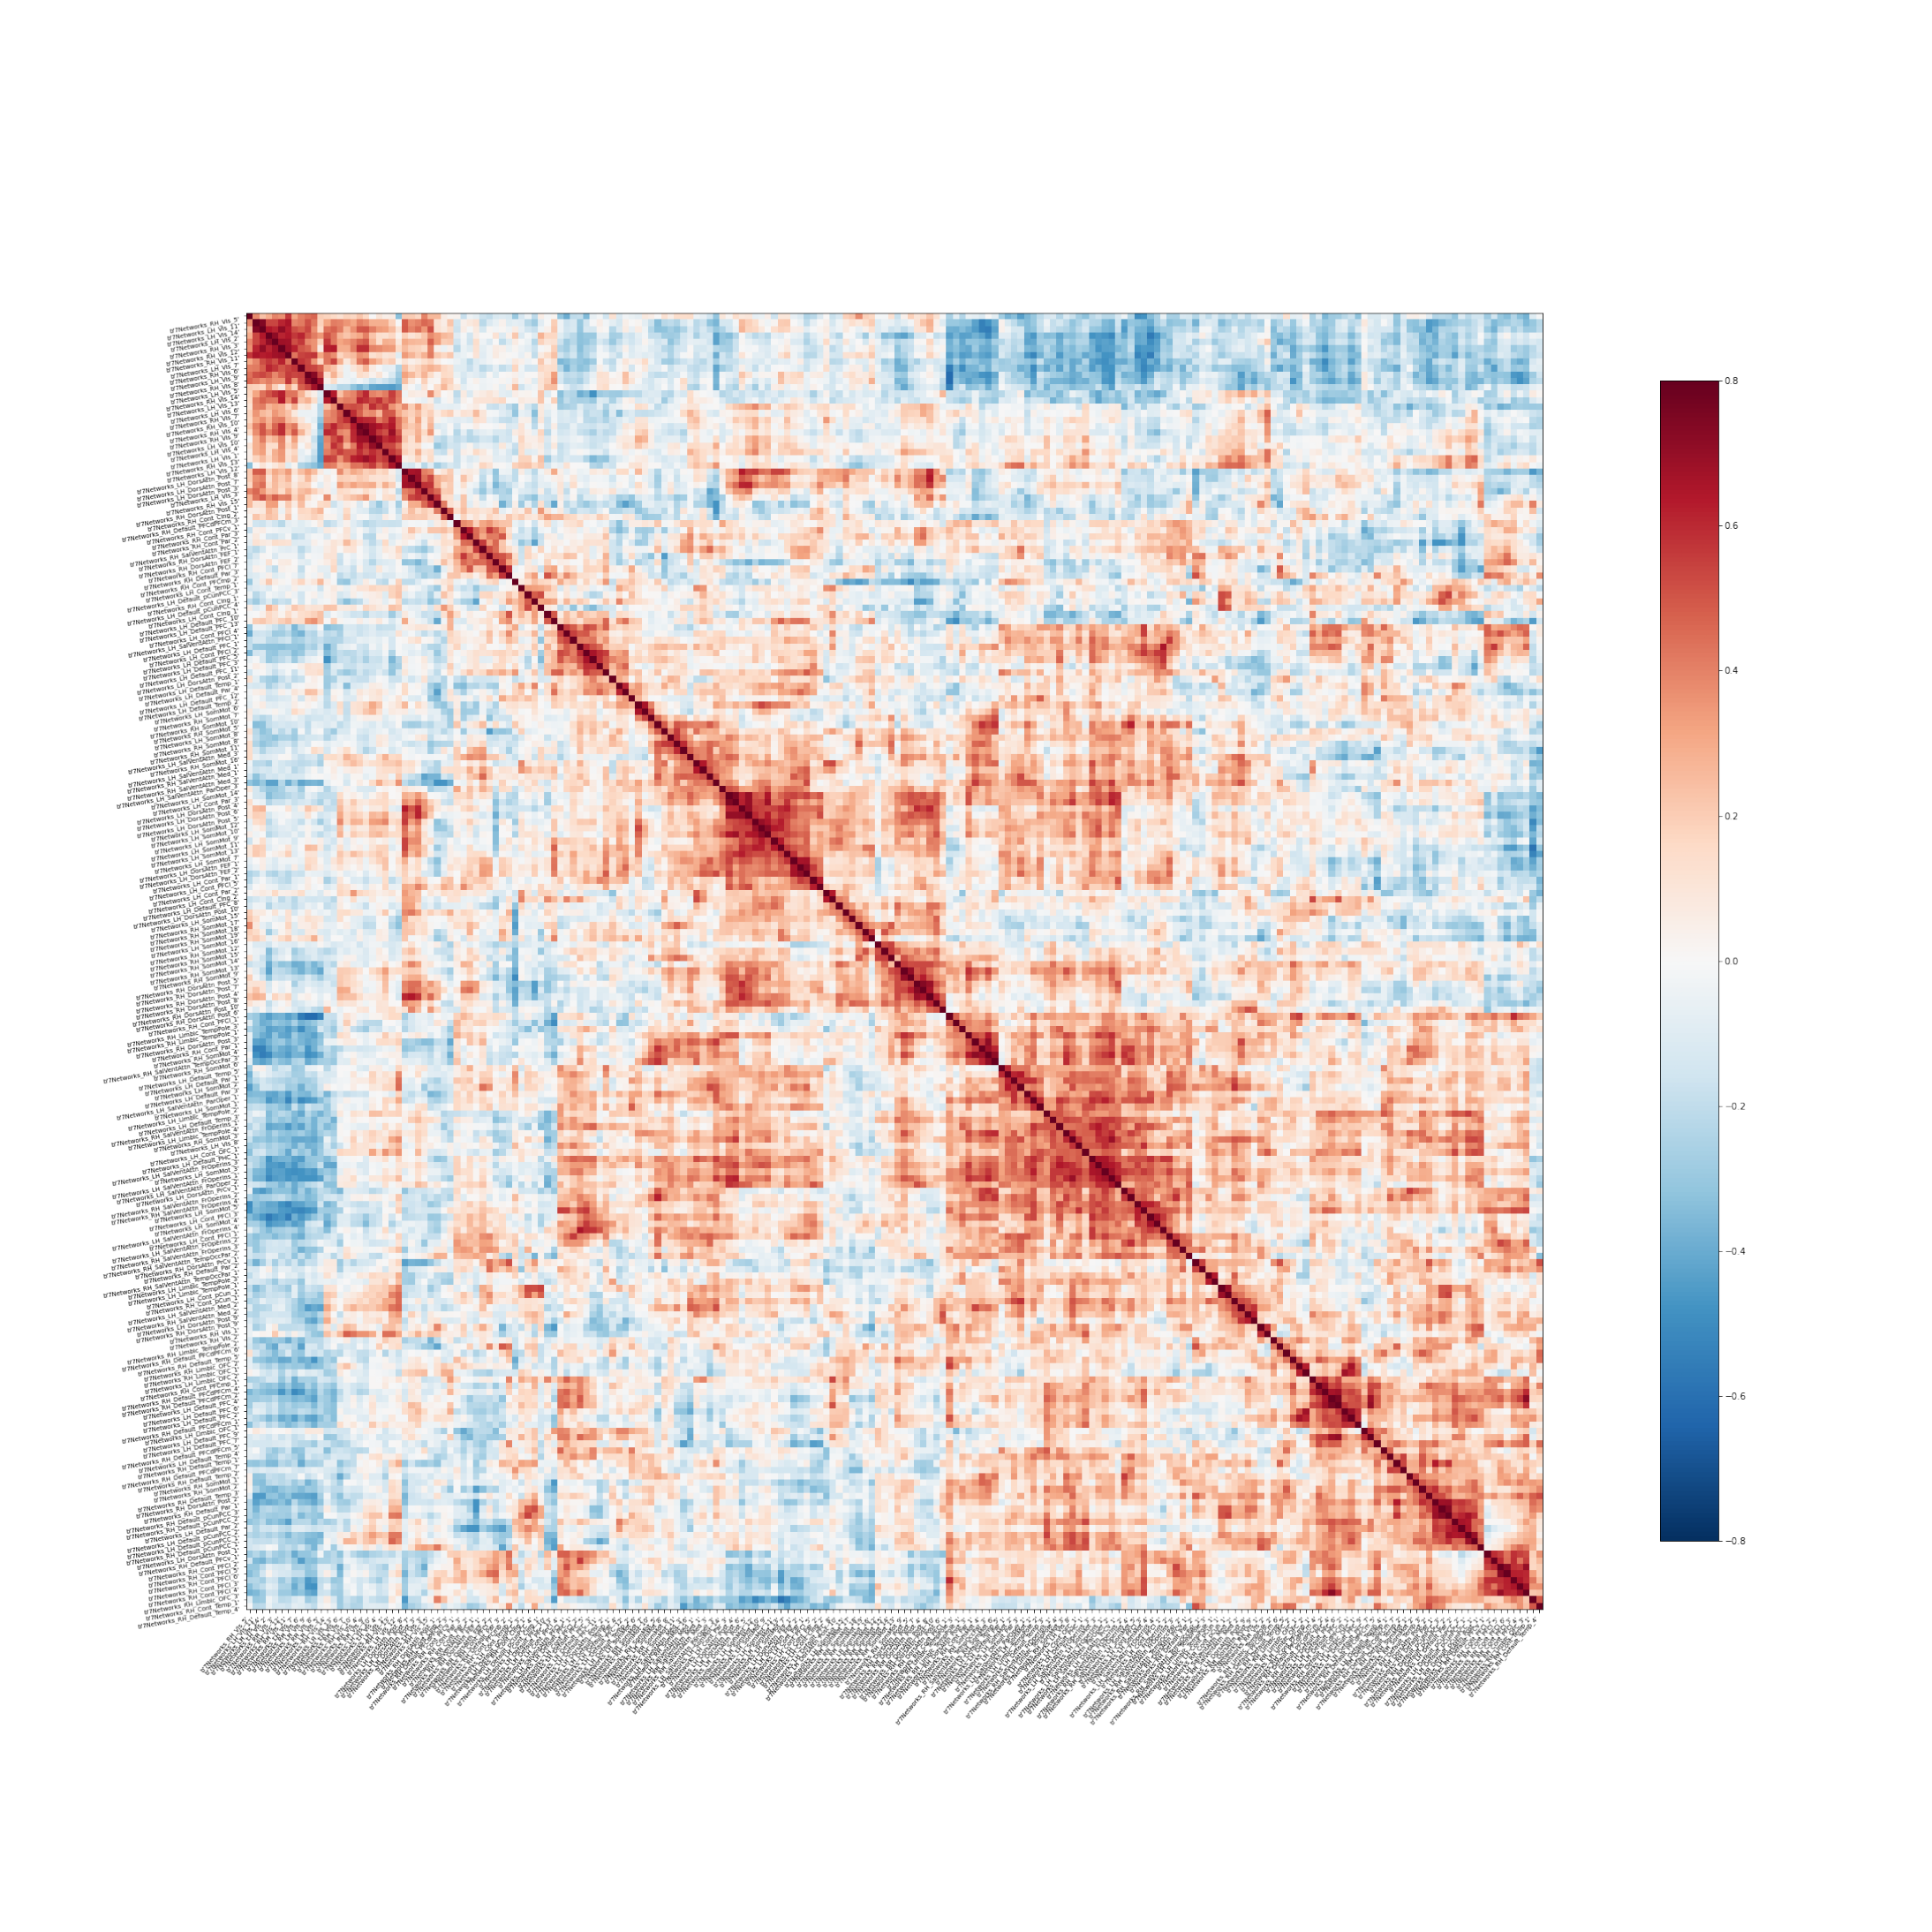

In [34]:


# reading png image
im = img.imread('/fast_scratch/jdr/resting/connMatrices/sub-009/ses-01/correlation/sub-009_ses-01_atlas-Schaefer200_kind-correlation_connectivity_matrix_labels_ordered.png')
plt.figure(figsize = (40,40))
plt.axis('off')
plt.imshow(im)

In [21]:
labels_schaefer

array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
       b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4',
       b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6',
       b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
       b'7Networks_LH_Vis_9', b'7Networks_LH_Vis_10',
       b'7Networks_LH_Vis_11', b'7Networks_LH_Vis_12',
       b'7Networks_LH_Vis_13', b'7Networks_LH_Vis_14',
       b'7Networks_LH_SomMot_1', b'7Networks_LH_SomMot_2',
       b'7Networks_LH_SomMot_3', b'7Networks_LH_SomMot_4',
       b'7Networks_LH_SomMot_5', b'7Networks_LH_SomMot_6',
       b'7Networks_LH_SomMot_7', b'7Networks_LH_SomMot_8',
       b'7Networks_LH_SomMot_9', b'7Networks_LH_SomMot_10',
       b'7Networks_LH_SomMot_11', b'7Networks_LH_SomMot_12',
       b'7Networks_LH_SomMot_13', b'7Networks_LH_SomMot_14',
       b'7Networks_LH_SomMot_15', b'7Networks_LH_SomMot_16',
       b'7Networks_LH_DorsAttn_Post_1', b'7Networks_LH_DorsAttn_Post_2',
       b'7Networks_LH_DorsAttn_Post_3', b'7Networks_LH_DorsAttn_Post_4',